# Problem Statement

An education company named X Education sells online courses to industry professionals. 

X Education wants to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. They wants to build a mdoel, wherein a leadscore is assigned to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Goals of the case study.

- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

- There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

# Importing Files and Reading dataset

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
leads = pd.read_csv("Leads.csv")
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
leads.shape

(9240, 37)

In [6]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [7]:
# Check dataset balancing from target variable -
print("Dataset balance as per Target Variable:")
print("-"*20)
round((leads['Converted'].value_counts()/len(leads['Converted']))*100, 2)

Dataset balance as per Target Variable:
--------------------


0    61.46
1    38.54
Name: Converted, dtype: float64

# EDA

## Handling NULL Values

### Converting Select to NaN

In [8]:
leads = leads.replace("Select", np.nan)

In [9]:
# Percentage of null values in the dataset

leads_null = leads.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 17


,Column Name,Missing Value
13,How did you hear about X Education,78.463203
28,Lead Profile,74.188312
25,Lead Quality,51.590909
33,Asymmetrique Profile Score,45.649351
32,Asymmetrique Activity Score,45.649351
30,Asymmetrique Activity Index,45.649351
31,Asymmetrique Profile Index,45.649351
29,City,39.707792
12,Specialization,36.580087
24,Tags,36.287879


In [10]:
print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Columns with more than 50% NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 50]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 20
Columns with NULL values in the dataset: 17
Columns with more than 50% NULL values in the dataset: 3
Total Columns in the dataset: 37


In [11]:
# create a copy of dataset before dropping any columns for backup purpose
lead_df = leads.copy()

###### Creating a list of columns where NULL value % is greater than 50%. We will drop these columns and will not include these further in the analysis

In [12]:
lead_null_greaterthan50 = leads_null[leads_null["Missing Value"] >= 50]

lead_col_drop = list(lead_null_greaterthan50.iloc[:, 0])
lead_col_drop

['How did you hear about X Education', 'Lead Profile', 'Lead Quality']

In [13]:
lead_df.drop(lead_col_drop, axis = 1, inplace = True)
lead_df.shape

(9240, 34)

### Check Unique values in all columns

In [14]:
lead_df_nunique = lead_df.nunique().reset_index()
lead_df_nunique = lead_df_nunique.rename(columns = {"index": "Column Name", 0:"Unique Values in col"})
lead_df_nunique.sort_values(by = "Unique Values in col", ascending = False, inplace = True)
lead_df_nunique

,Column Name,Unique Values in col
0,Prospect ID,9240
1,Lead Number,9240
8,Total Time Spent on Website,1731
9,Page Views Per Visit,114
7,TotalVisits,41
11,Country,38
23,Tags,26
3,Lead Source,21
12,Specialization,18
10,Last Activity,17


Columns which has same value across the entire data frame is of no use for modelling as they will not be able to uniquely qualify any entry. Hence we will remove all entries where `unique values in a column` is 1.

Similarly, Prospect ID and Lead Number both uniquely identifies each row in the dataset and hence we do not need 2 columns.

In [15]:
lead_single_val = lead_df_nunique[lead_df_nunique["Unique Values in col"] == 1]

lead_col_drop = list(lead_single_val.iloc[:, 0])
lead_col_drop.append("Prospect ID")
lead_col_drop

['Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Magazine',
 'I agree to pay the amount through cheque',
 'Receive More Updates About Our Courses',
 'Prospect ID']

In [16]:
lead_df.drop(lead_col_drop, axis = 1, inplace = True)
lead_df.shape

(9240, 28)

In [17]:
for col in lead_df.columns[1:]:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False))
    print("-"*30)
    print()

Lead Origin :
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64
------------------------------

Lead Source :
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64
------------------------------

Do Not Email :
No     8506
Yes     734
Name: Do Not Email, dtype: int64
------------------------------

Do Not C

In [18]:
lead_df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Do Not Email',
       'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags', 'City',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [19]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 14


,Column Name,Missing Value
22,Asymmetrique Activity Index,45.649351
25,Asymmetrique Profile Score,45.649351
24,Asymmetrique Activity Score,45.649351
23,Asymmetrique Profile Index,45.649351
21,City,39.707792
11,Specialization,36.580087
20,Tags,36.287879
13,What matters most to you in choosing a course,29.318182
12,What is your current occupation,29.112554
10,Country,26.634199


In [20]:
print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Columns with more than 50% NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 50]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 14
Columns with NULL values in the dataset: 14
Columns with more than 50% NULL values in the dataset: 0
Total Columns in the dataset: 28


In [21]:
# check columns with null values > 45%
lead_null_greaterthan45 = leads_null[leads_null["Missing Value"] >= 45]

lead_col = list(lead_null_greaterthan45.iloc[:, 0])
lead_col

['Asymmetrique Activity Index',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Index']

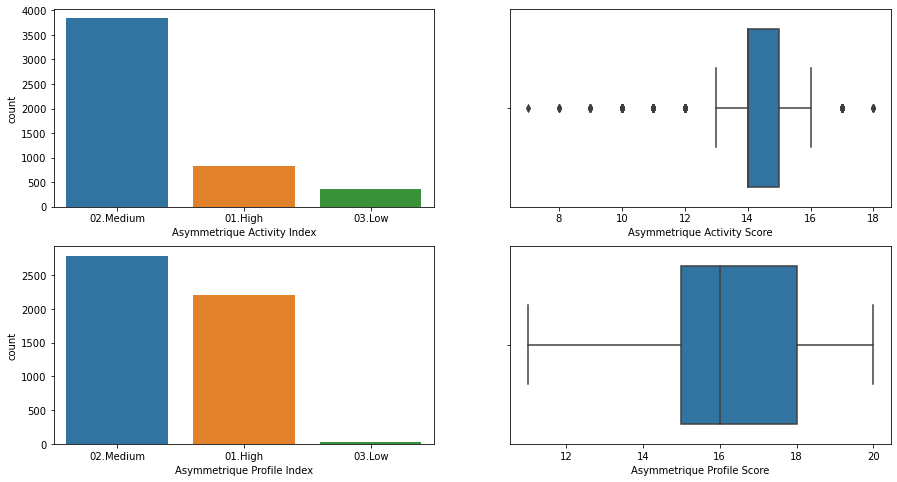

In [22]:
fig, axs = plt.subplots(2,2, figsize = (15,8))

plt1 = sns.countplot(lead_df['Asymmetrique Activity Index'], ax = axs[0,0])
plt2 = sns.boxplot(lead_df['Asymmetrique Activity Score'], ax = axs[0,1])
plt3 = sns.countplot(lead_df['Asymmetrique Profile Index'], ax = axs[1,0])
plt4 = sns.boxplot(lead_df['Asymmetrique Profile Score'], ax = axs[1,1])
plt.show()

From the dataset and data dictionary, this can be notices that, Activity Index and Profile Index are derived from the Activity Score and Profile Score Columns.  
Hence, we can remove Activity Score and Profile Score columns from the dataset.

Also, in Activity Index and Profile Index, no trend can be noticed here and since the missing values are huge (45%) and imputing any values in the field might skew the results. 
Hence, we will remove these columns from the dataset

In [23]:
lead_df.drop(lead_col, axis = 1, inplace = True)
lead_df.shape

(9240, 24)

In [24]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 10


,Column Name,Missing Value
21,City,39.707792
11,Specialization,36.580087
20,Tags,36.287879
13,What matters most to you in choosing a course,29.318182
12,What is your current occupation,29.112554
10,Country,26.634199
6,TotalVisits,1.482684
8,Page Views Per Visit,1.482684
9,Last Activity,1.114719
2,Lead Source,0.389610


In [25]:
# checking the values in these columns where null value is available

cols = leads_null[leads_null['Missing Value'] > 0].copy()

for col in cols['Column Name']:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False))
    print("-"*30)
    print()

City :
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64
------------------------------

Specialization :
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                    

In [26]:
# check columns with null values < 2%
lead_null_lessthan2 = leads_null[(leads_null["Missing Value"] < 2) & (leads_null["Missing Value"] > 0)]

lead_col = list(lead_null_lessthan2.iloc[:, 0])
lead_col

['TotalVisits', 'Page Views Per Visit', 'Last Activity', 'Lead Source']

In [27]:
# We will drop those rows where null values are less than 2% as it will not impact our analysis

lead_df.dropna(subset=lead_col, inplace = True)
lead_df.shape

(9074, 24)

#### Specialization

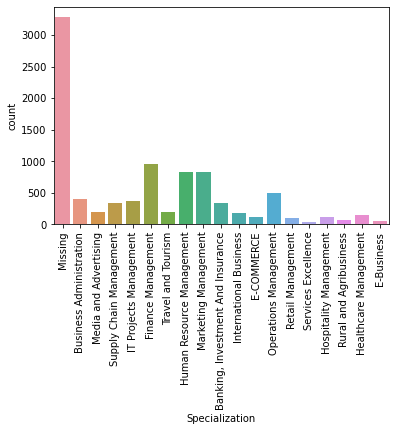

In [28]:
sns.countplot(lead_df['Specialization'].fillna('Missing'))
plt.xticks(rotation = 90)
plt.show()

In [29]:
# It can be clearly noticed that null values in specialization are not linked to any other value, 
# hence we will impute "Others" in the field

lead_df['Specialization'] = lead_df['Specialization'].replace(np.nan, 'Others')

In [30]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 5


,Column Name,Missing Value
21,City,39.398281
20,Tags,36.665197
13,What matters most to you in choosing a course,29.777386
12,What is your current occupation,29.567996
10,Country,25.303064


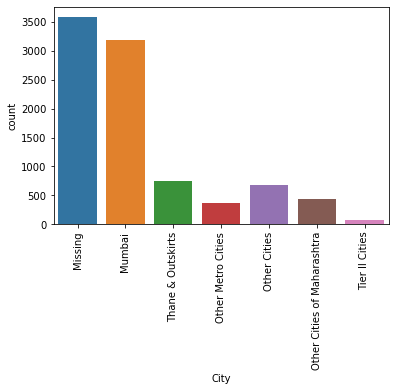

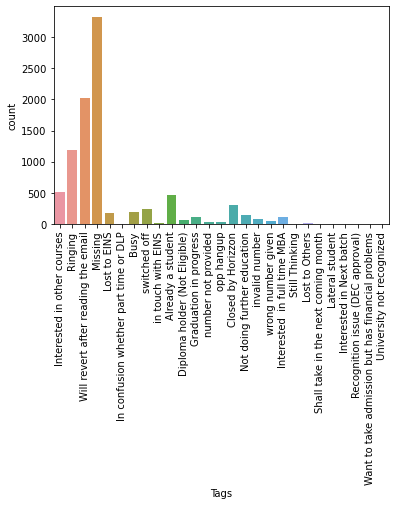

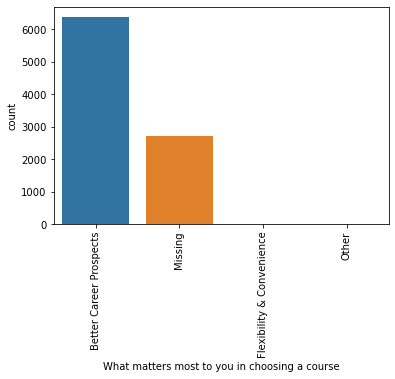

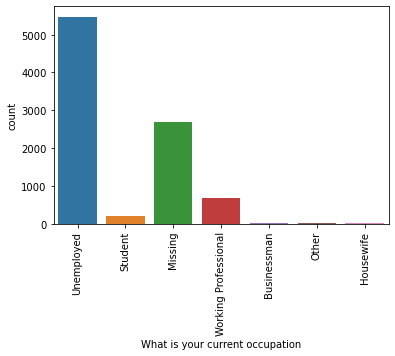

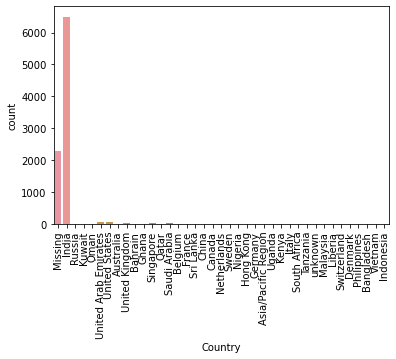

In [31]:
remain_col = leads_null[leads_null['Missing Value'] > 0].copy()

for col in remain_col['Column Name']: 
    sns.countplot(lead_df[col].fillna('Missing'))
    plt.xticks(rotation = 90)
    plt.show()

In [32]:
# For the remaining columns, we can impute the mode value in null values in the respective columns as 
# these are generalized terms and can be imputed in the chart

for col in remain_col['Column Name']:
    lead_df[col].fillna(lead_df[col].mode().values[0], inplace=True)

In [33]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 24
Columns with NULL values in the dataset: 0
Total Columns in the dataset: 24


##### Below is the final column list from the dataset with no null values in any column

In [34]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Number                                    9074 non-null   int64  
 1   Lead Origin                                    9074 non-null   object 
 2   Lead Source                                    9074 non-null   object 
 3   Do Not Email                                   9074 non-null   object 
 4   Do Not Call                                    9074 non-null   object 
 5   Converted                                      9074 non-null   int64  
 6   TotalVisits                                    9074 non-null   float64
 7   Total Time Spent on Website                    9074 non-null   int64  
 8   Page Views Per Visit                           9074 non-null   float64
 9   Last Activity                                  9074 

## Univariate/ Bivariate Analysis

In [35]:
# We will bifurcate the field list in different sets to easily analyze teh column values
set_1 = ['Country', 'City', 'Specialization', 'Lead Source', 'Lead Origin', 'Last Activity', 'Last Notable Activity'] 
set_2 = ['What is your current occupation', 'What matters most to you in choosing a course', 'Tags']
set_3 = ['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper',
         'Digital Advertisement', 'Through Recommendations', 'A free copy of Mastering The Interview']
set_4 = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

### Analysis of set_1

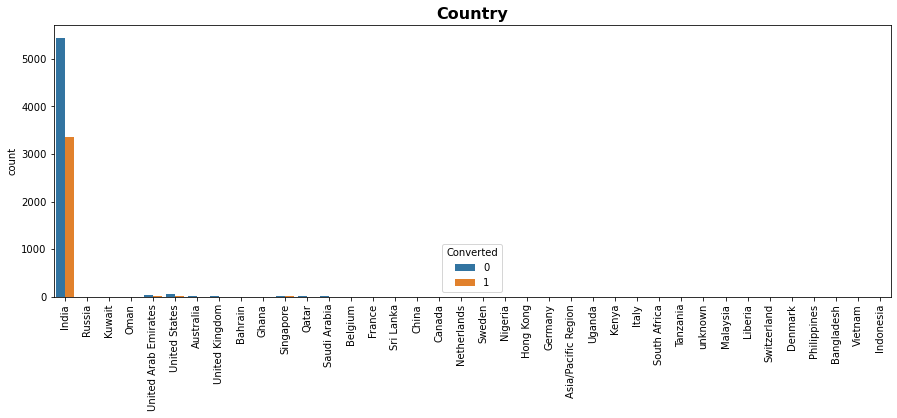

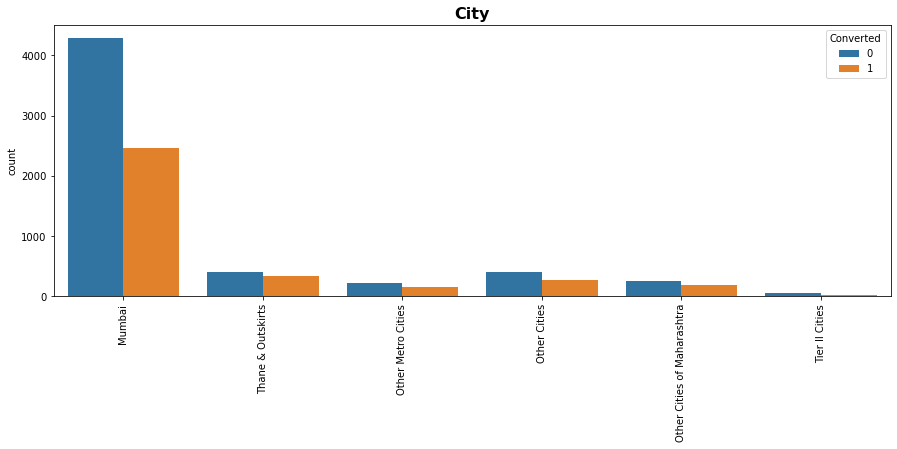

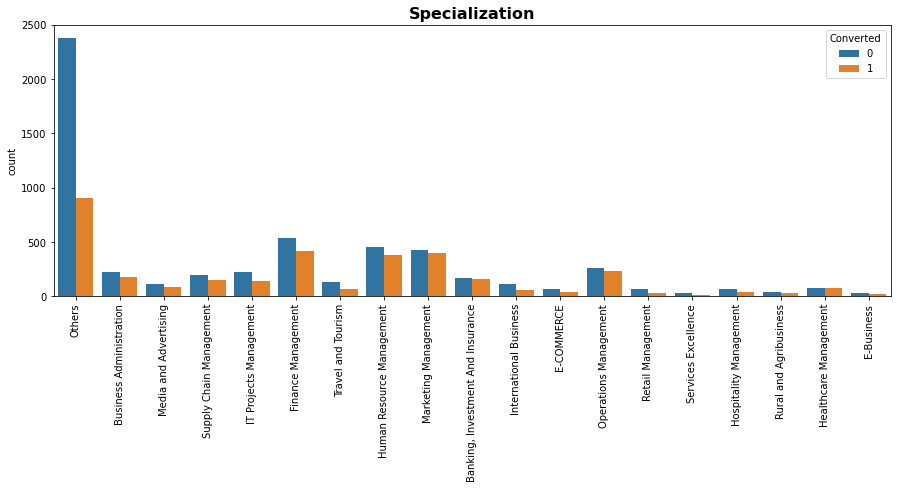

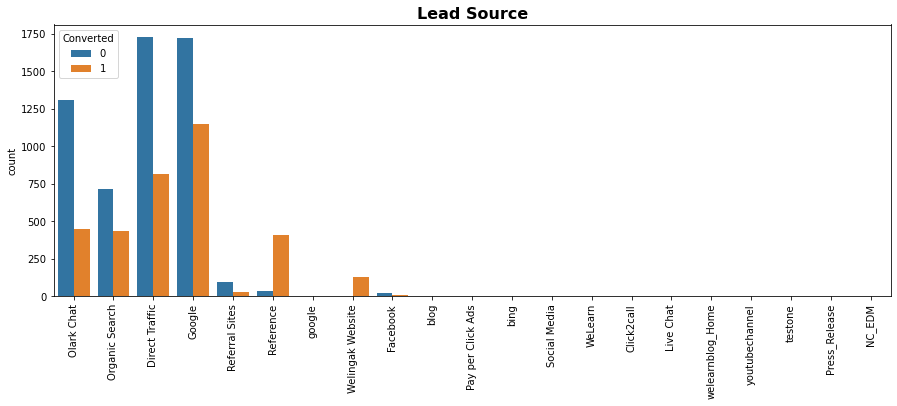

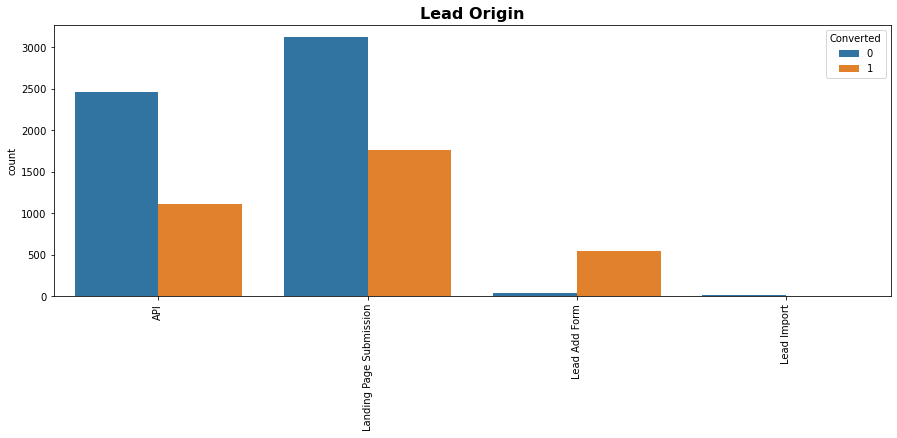

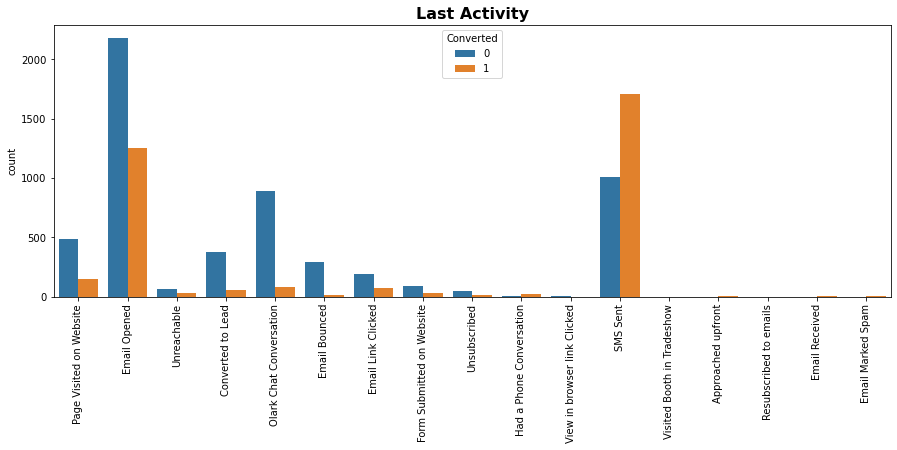

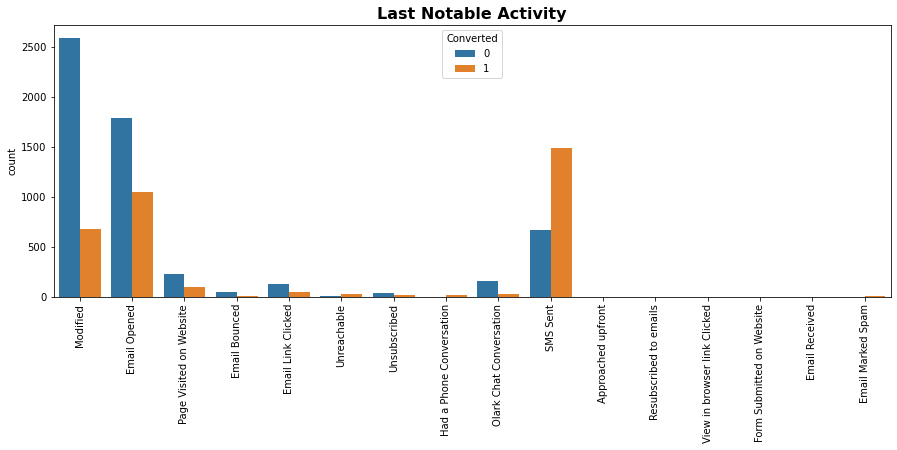

In [36]:
for i in set_1:
    
    plt.figure(figsize=(15, 5))
    sns.countplot(lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.xlabel(xlabel = "")
    plt.show()

##### Observations -
- `Country` - As this is clearly visible that 90%+ of data is concentrated to India Region and this data is highly skewed, hence we will not be able to derive any insights from this field, hence it is okay to remove this field from the dataset   
- `City` - Maximum footfall is from Mumbai region. We can draw some insights from this column
- `Specialization` - We can use this column to draw some insights
- `Lead Source` - This column can be used to draw some insights however, we need to clean and standardize this field as we can see that there are repetitive values in the field
- `Lead Origin` - 
    - Highest number of leads as well as conversions can be seen from API and Landing Page Submission
    - Lead Add Form gives a very high conversion rate but count of leads are not very high
    - Lead Import get very few leads
- `Last Activity` - This column can be used to draw some insights however, we need to clean and standardize this field as we can see that there are values which have very miniscule count and can be merged and represented as Others
- `Last Notable Activity` - This column can be used to draw some insights however, we need to clean and standardize this field as we can see that there are values which have very miniscule count and can be merged and represented as Others

In [37]:
# List which contains all columns which can be dropped from the dataset

drop_cols = ['Country']

In [38]:
# Modification in Lead Source
lead_df['Lead Source'] = lead_df['Lead Source'].replace('google','Google')
lead_df['Lead Source'] = lead_df['Lead Source'].replace('Facebook','Social Media')
lead_df['Lead Source'] = lead_df['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others') 

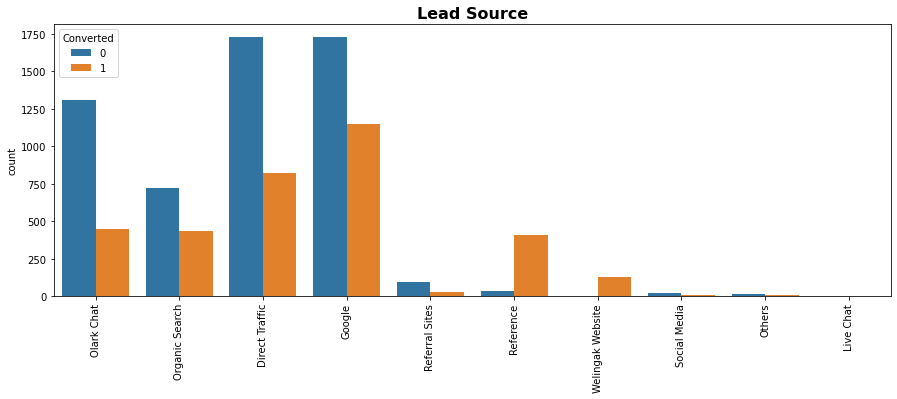

In [39]:
plt.figure(figsize=(15, 5))
sns.countplot(lead_df['Lead Source'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title("Lead Source", fontsize=16, fontweight = "bold")
plt.xlabel(xlabel = "")
plt.show()

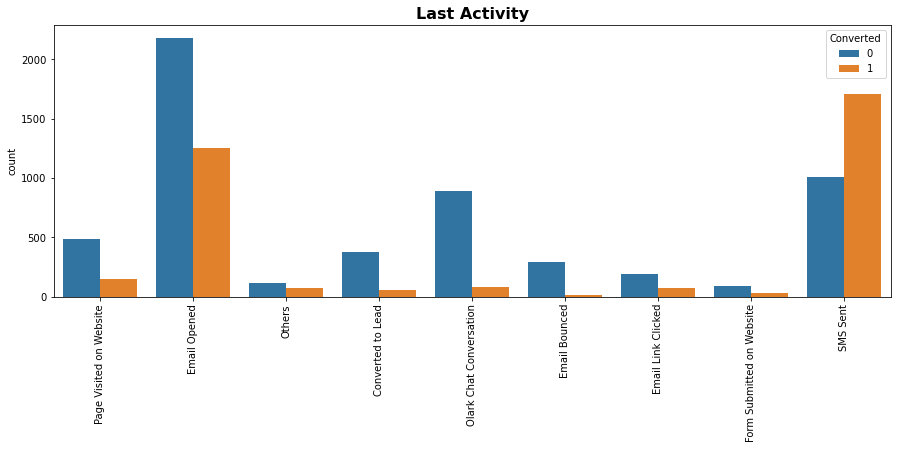

In [40]:
# Modification in Last Notable Activity
lead_df['Last Activity'] = lead_df['Last Activity'].replace(['Unreachable','Unsubscribed', 'Had a Phone Conversation', 
                                                        'Approached upfront', 'View in browser link Clicked',       
                                                        'Email Marked Spam',  'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

plt.figure(figsize=(15, 5))
sns.countplot(lead_df['Last Activity'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title('Last Activity', fontsize=16, fontweight = "bold")
plt.xlabel(xlabel = "")
plt.show()

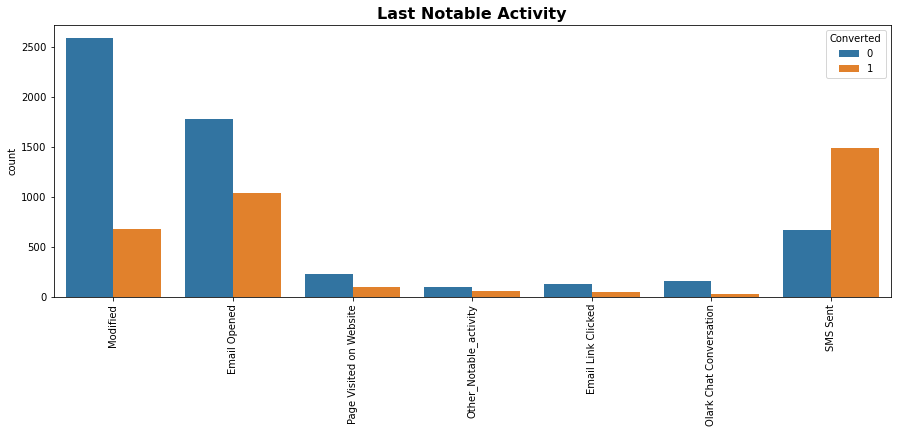

In [41]:
# Modification in Last Notable Activity
lead_df['Last Notable Activity'] = lead_df['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam', 'Unreachable', 'Unsubscribed', 
                                                                        'Email Bounced', 'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')

plt.figure(figsize=(15, 5))
sns.countplot(lead_df['Last Notable Activity'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title('Last Notable Activity', fontsize=16, fontweight = "bold")
plt.xlabel(xlabel = "")
plt.show()

### Analysis of set_2

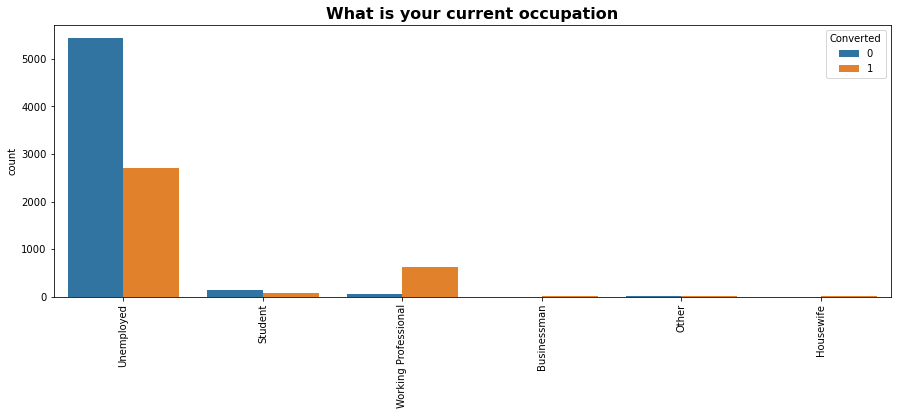

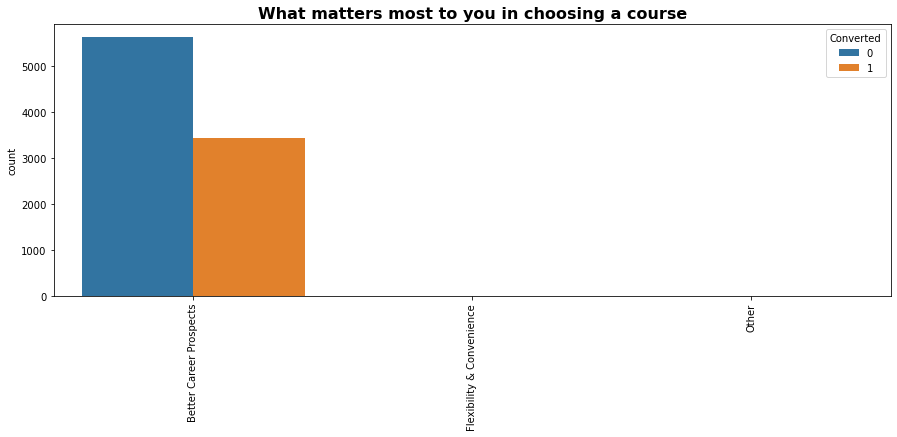

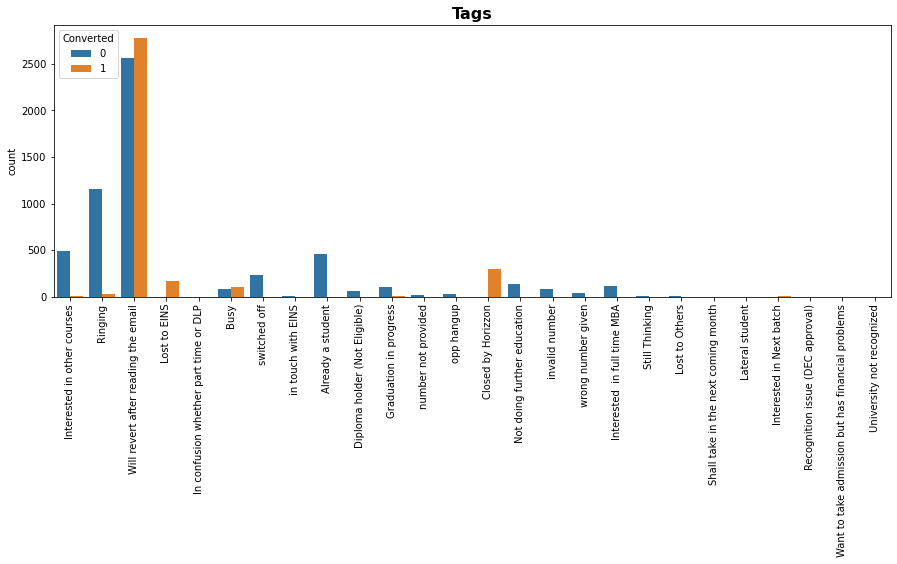

In [42]:
for i in set_2:
    plt.figure(figsize=(15, 5))
    sns.countplot(lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.xlabel(xlabel = "")
    plt.show()

##### Observations -
- `What is your current occupation` - 
    - Working Professionals have high conversion rates
    - Maximum leads are generated from Unemployed population
- `What matters most to you in choosing a course` - Since 99% of the data is skewed, we can drop this field
- `Tags` - This column can be used to draw some insights however, we need to clean and standardize this field as we can see that there are values which have very miniscule count and can be merged and represented as Others

In [43]:
# List which contains all columns which can be dropped from the dataset

drop_cols.append('What matters most to you in choosing a course')
drop_cols

['Country', 'What matters most to you in choosing a course']

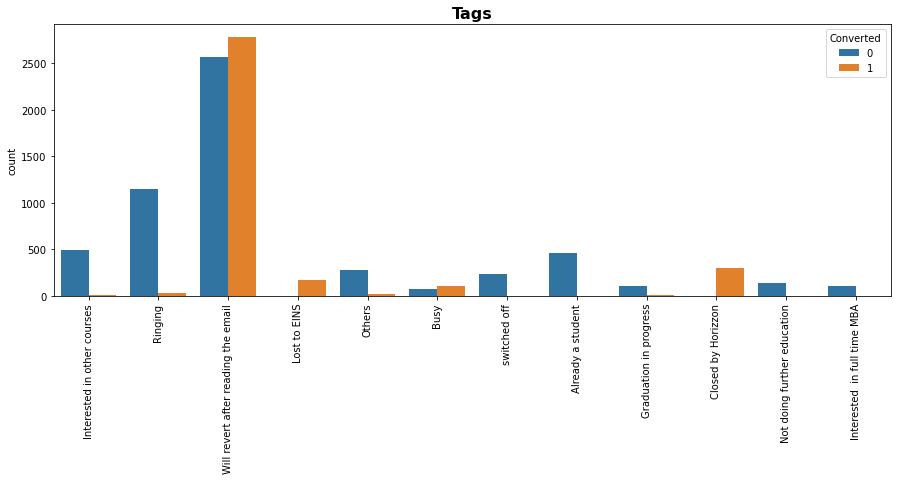

In [44]:
lead_df['Tags'] = lead_df['Tags'].replace(['invalid number', 'Diploma holder (Not Eligible)', 'wrong number given',
                                           'opp hangup', 'number not provided', 'in touch with EINS', 'Lost to Others',
                                           'Want to take admission but has financial problems', 'Still Thinking',
                                           'Interested in Next batch', 'In confusion whether part time or DLP',
                                           'Lateral student', 'Shall take in the next coming month', 
                                           'University not recognized', 'Recognition issue (DEC approval)'], 'Others')

plt.figure(figsize=(15, 5))
sns.countplot(lead_df['Tags'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title('Tags', fontsize=16, fontweight = "bold")
plt.xlabel(xlabel = "")
plt.show()

### Analysis of set_3

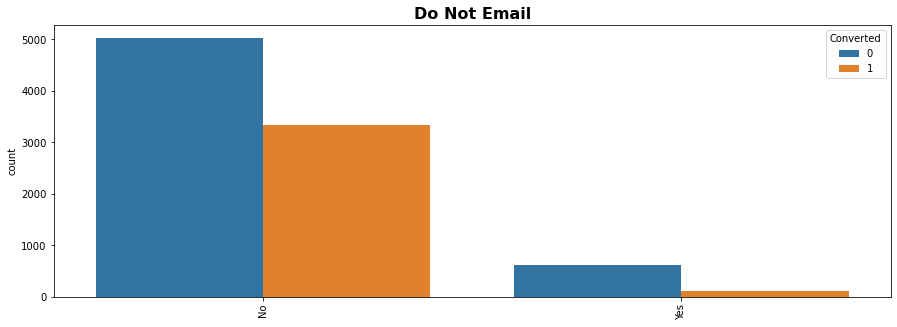

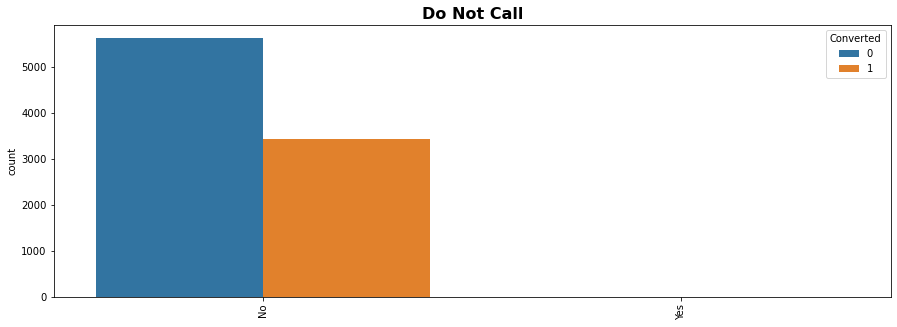

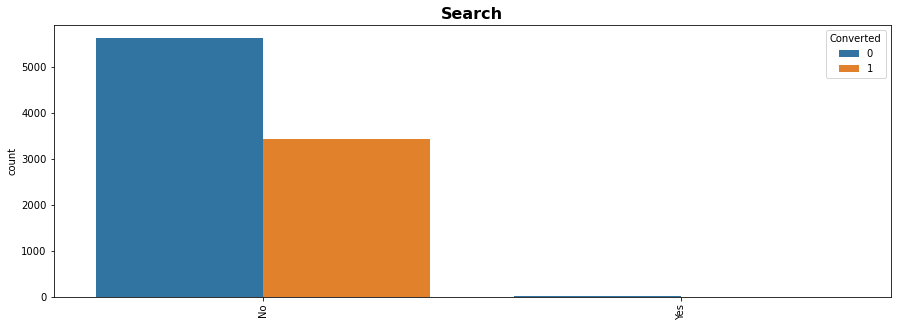

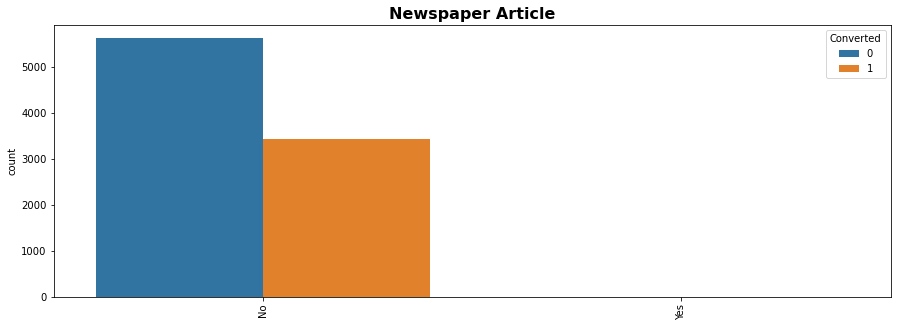

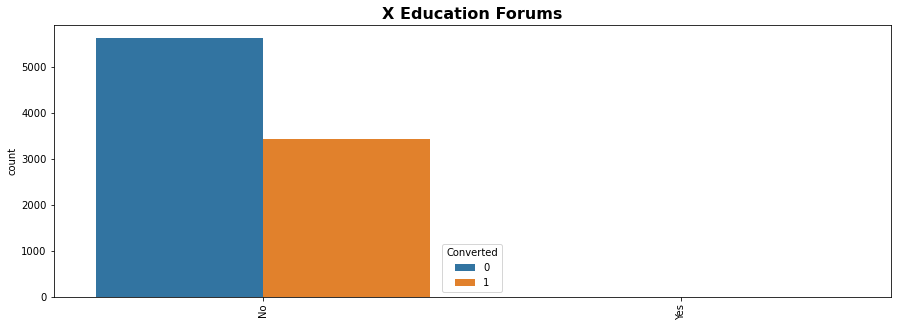

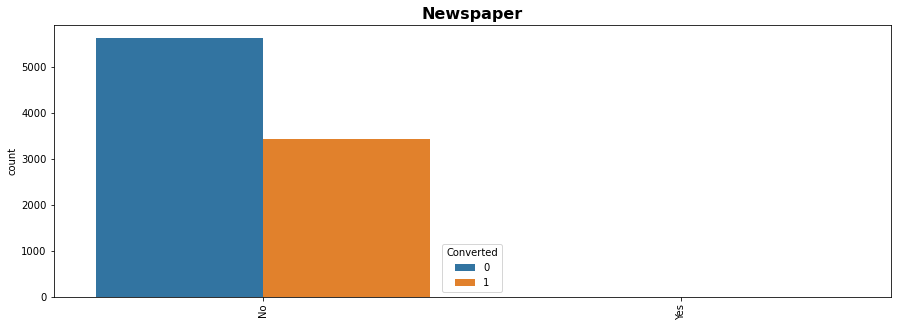

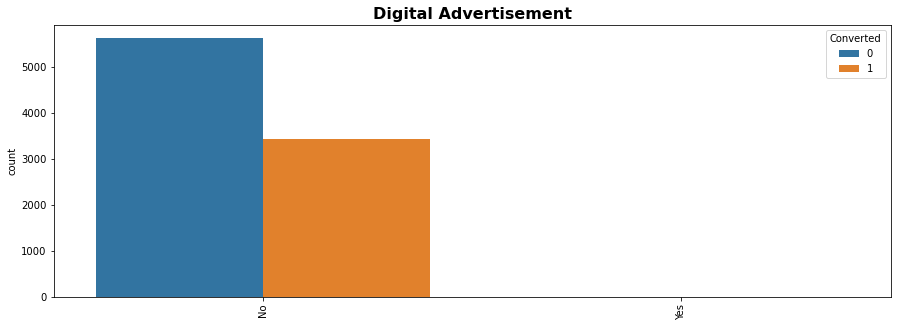

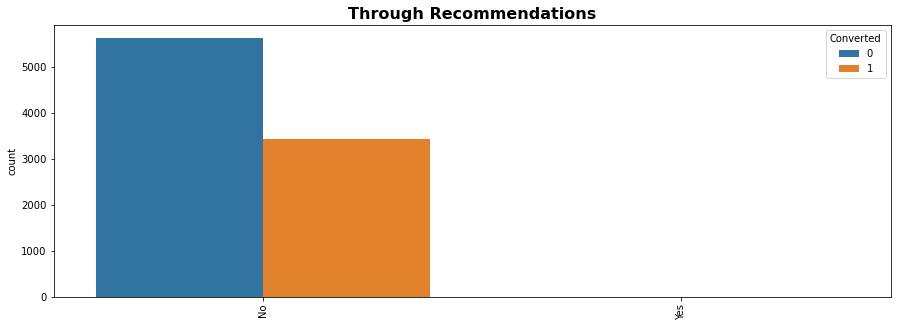

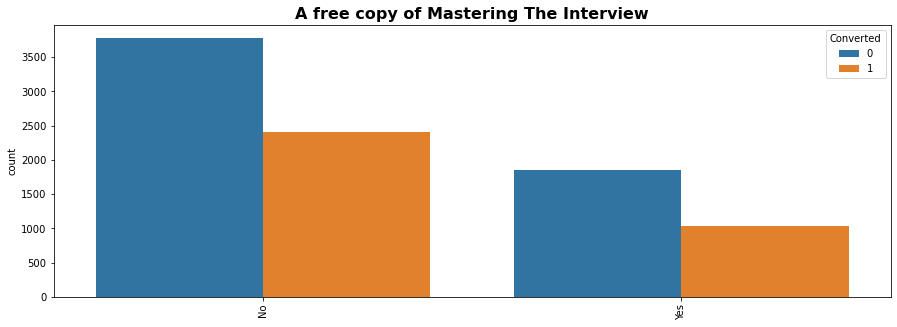

In [45]:
for i in set_3:
    plt.figure(figsize=(15, 5))
    sns.countplot(lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.xlabel(xlabel = "")
    plt.show()

##### Observations -
- `Do Not Email` - Maximum customers have mentioned No to this but have still converted   
- `Do Not Call` - This column is highly skewed as 99% of data is in No category
- `Search` - This column is highly skewed as 99% of data is in No category
- `Newspaper Article` - This column is highly skewed as 99% of data is in No category
- `X Education Forums` - This column is highly skewed as 99% of data is in No category
- `Newspaper` - This column is highly skewed as 99% of data is in No category
- `Digital Advertisement` - This column is highly skewed as 99% of data is in No category
- `Through Recommendations` - This column is highly skewed as 99% of data is in No category
- `A free copy of Mastering The Interview` -This can be used in the modeling to check if this feature has any impact on conversion 

In [46]:
# List which contains all columns which can be dropped from the dataset

drop_cols.extend(['Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement',
                  'Through Recommendations'])
drop_cols

['Country',
 'What matters most to you in choosing a course',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations']

### Analysis of set_4

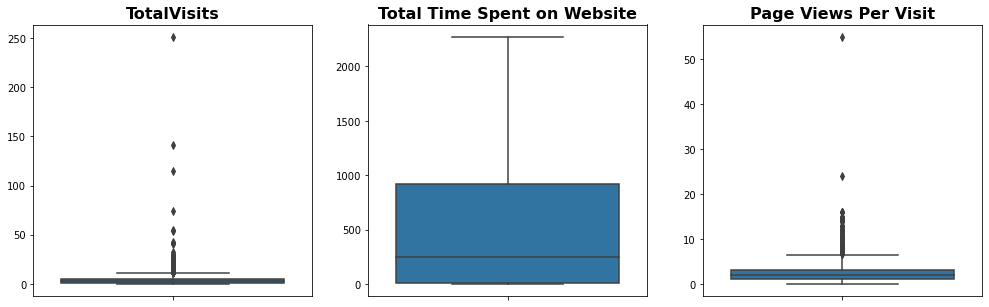

In [47]:
j = 0
plt.subplots(1, 3, figsize=(17, 5))
for i in set_4:
    j += 1
    plt.subplot(1, 3, j)
    sns.boxplot(y = lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.ylabel(ylabel = "")
plt.show()

##### Observations -
- `TotalVisits` - There are outliers in the field and hence we can check after removing the outliers
- `Total Time Spent on Website` - No outliers present in the column and hence this can be used as is in modeling
- `Page Views Per Visit` - There are outliers in the field and hence we can check after removing the outliers

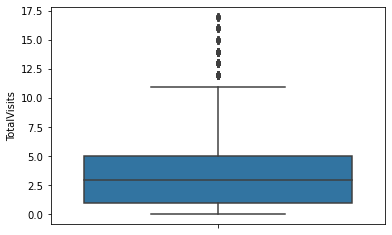

In [48]:
# TotalVisits - Outlier Treatment - Remove top & bottom 1% of the Column Outlier values

Q3 = lead_df.TotalVisits.quantile(0.99)
lead_df = lead_df[(lead_df.TotalVisits <= Q3)]
Q1 = lead_df.TotalVisits.quantile(0.01)
lead_df = lead_df[(lead_df.TotalVisits >= Q1)]
sns.boxplot(y=lead_df['TotalVisits'])
plt.show()

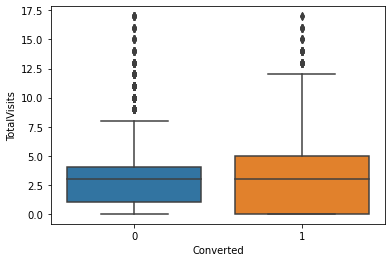

In [49]:
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = lead_df)
plt.show()

- Median for converted and non-converted leads are same

In [50]:
lead_df.shape

(8991, 24)

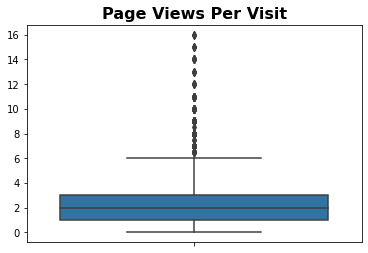

In [51]:
# Check Page Views Per Visit field after outlier treatment for Totalvisits column

sns.boxplot(y = lead_df['Page Views Per Visit'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title('Page Views Per Visit', fontsize=16, fontweight = "bold")
plt.ylabel(ylabel = "")
plt.show()

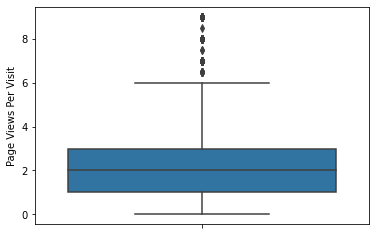

In [52]:
# Page Views Per Visit - Outlier Treatment - Remove top & bottom 1% of the Column Outlier values

Q3 = lead_df['Page Views Per Visit'].quantile(0.99)
lead_df = lead_df[(lead_df['Page Views Per Visit'] <= Q3)]
Q1 = lead_df['Page Views Per Visit'].quantile(0.01)
lead_df = lead_df[(lead_df['Page Views Per Visit'] >= Q1)]
sns.boxplot(y=lead_df['Page Views Per Visit'])
plt.show()

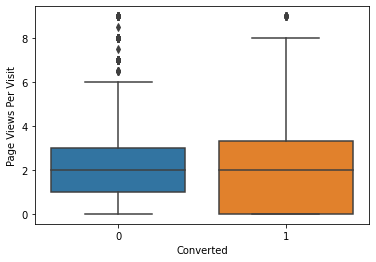

In [53]:
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = lead_df)
plt.show()

- Median for converted and non-converted leads are same

In [54]:
lead_df.shape

(8924, 24)

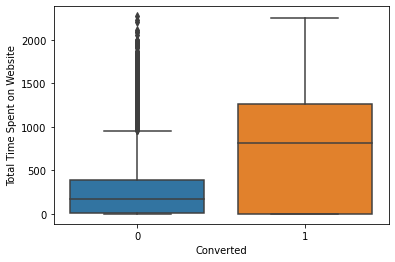

In [55]:
# coparison for Total Time Spent on Website with target variable
sns.boxplot(y = 'Total Time Spent on Website', x = 'Converted', data = lead_df)
plt.show()

- Leads spending more time on website have high conversion rate probability

In [56]:
# Final list of columns to be dropped from dataset -
drop_cols

['Country',
 'What matters most to you in choosing a course',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations']

In [57]:
lead_df.drop(drop_cols, axis = 1, inplace = True)
lead_df.shape

(8924, 15)

In [58]:
print("Final Dataset values retained post null value handling and univariate/bivariate analysis is :")
print("-"*84)
round((lead_df.shape[0]/leads.shape[0])*100, 2)

Final Dataset values retained post null value handling and univariate/bivariate analysis is :
------------------------------------------------------------------------------------


96.58

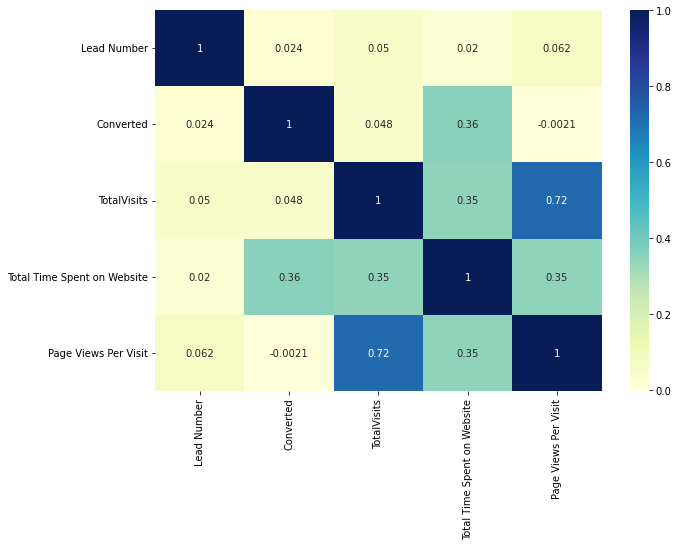

In [59]:
plt.figure(figsize=(10,7))
sns.heatmap(lead_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

# Data Preparation for Modeling

## Dummy Variable Creation

In [60]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8924 entries, 0 to 9239
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             8924 non-null   int64  
 1   Lead Origin                             8924 non-null   object 
 2   Lead Source                             8924 non-null   object 
 3   Do Not Email                            8924 non-null   object 
 4   Converted                               8924 non-null   int64  
 5   TotalVisits                             8924 non-null   float64
 6   Total Time Spent on Website             8924 non-null   int64  
 7   Page Views Per Visit                    8924 non-null   float64
 8   Last Activity                           8924 non-null   object 
 9   Specialization                          8924 non-null   object 
 10  What is your current occupation         8924 non-null   obje

In [61]:
category_cols= lead_df.select_dtypes(include=['object']).columns

for col in category_cols:
    print("-------", col, "-------")
    print(lead_df[col].value_counts())
    print("-"*40)

------- Lead Origin -------
Landing Page Submission    4768
API                        3546
Lead Add Form               580
Lead Import                  30
Name: Lead Origin, dtype: int64
----------------------------------------
------- Lead Source -------
Google              2841
Direct Traffic      2499
Olark Chat          1751
Organic Search      1092
Reference            442
Welingak Website     129
Referral Sites       117
Social Media          33
Others                18
Live Chat              2
Name: Lead Source, dtype: int64
----------------------------------------
------- Do Not Email -------
No     8235
Yes     689
Name: Do Not Email, dtype: int64
----------------------------------------
------- Last Activity -------
Email Opened                 3385
SMS Sent                     2678
Olark Chat Conversation       966
Page Visited on Website       594
Converted to Lead             428
Email Bounced                 310
Email Link Clicked            264
Others                   

In [62]:
# Converting Binary Variables (Yes/No) to 1/0

varlist =  ['Do Not Email', 'A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the list
lead_df[varlist] = lead_df[varlist].apply(binary_map)

lead_df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,Interested in other courses,Mumbai,0,Modified
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Others,Unemployed,Ringing,Mumbai,0,Email Opened
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,1,Email Opened
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,0,Modified
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,Will revert after reading the email,Mumbai,0,Modified


In [79]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(lead_df['Lead Origin'], prefix  = 'Origin', drop_first=True)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Lead Source'], prefix  = 'Source')
dummy = dummy.drop(['Source_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Last Activity'], prefix  = 'Activity')
dummy = dummy.drop(['Activity_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Specialization'], prefix  = 'Specialization')
dummy = dummy.drop(['Specialization_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['What is your current occupation'], prefix  = 'Occupation', drop_first=True)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Tags'], prefix  = 'Tags')
dummy = dummy.drop(['Tags_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['City'], prefix  = 'City')
dummy = dummy.drop(['City_Other Cities'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Last Notable Activity'], prefix  = 'Last Notable Activity')
dummy = dummy.drop(['Last Notable Activity_Other_Notable_activity'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

In [85]:
# After creating dummy variables, dropping original columns

lead_df.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation', 
              'Tags', 'City', 'Last Notable Activity'], axis = 1, inplace = True)

lead_df.columns

Index(['Lead Number', 'Do Not Email', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit',
       'A free copy of Mastering The Interview',
       'Origin_Landing Page Submission', 'Origin_Lead Add Form',
       'Origin_Lead Import', 'Source_Direct Traffic', 'Source_Google',
       'Source_Live Chat', 'Source_Olark Chat', 'Source_Organic Search',
       'Source_Reference', 'Source_Referral Sites', 'Source_Social Media',
       'Source_Welingak Website', 'Activity_Converted to Lead',
       'Activity_Email Bounced', 'Activity_Email Link Clicked',
       'Activity_Email Opened', 'Activity_Form Submitted on Website',
       'Activity_Olark Chat Conversation', 'Activity_Page Visited on Website',
       'Activity_SMS Sent', 'Specialization_Banking, Investment And Insurance',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthca

In [86]:
lead_df.shape

(8924, 72)

## Train Test Split

In [87]:
# Putting feature variable to X
X = lead_df.drop(['Lead Number','Converted'], axis=1)

# Putting response variable to y
y = lead_df['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [88]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Feature Scaling

In [90]:
scaler = StandardScaler()

numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,Source_Direct Traffic,Source_Google,Source_Live Chat,Source_Olark Chat,Source_Organic Search,Source_Reference,Source_Referral Sites,Source_Social Media,Source_Welingak Website,Activity_Converted to Lead,Activity_Email Bounced,Activity_Email Link Clicked,Activity_Email Opened,Activity_Form Submitted on Website,Activity_Olark Chat Conversation,Activity_Page Visited on Website,Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
6676,-0.285584,-0.049636,1.395668,0.395289,-0.669212,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
6138,-0.285584,0.297929,0.609686,0.926758,-0.669212,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
8650,-0.285584,-0.049636,1.178657,0.395289,1.494296,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3423,-0.285584,-1.092332,-0.878390,-1.199117,-0.669212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
6552,-0.285584,-1.092332,-0.878390,-1.199117,-0.669212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


In [92]:
### Checking the Conversion Rate
conversion_rate = (sum(lead_df['Converted'])/len(lead_df['Converted'].index))*100
conversion_rate

37.75212909009413

## Correlation in features

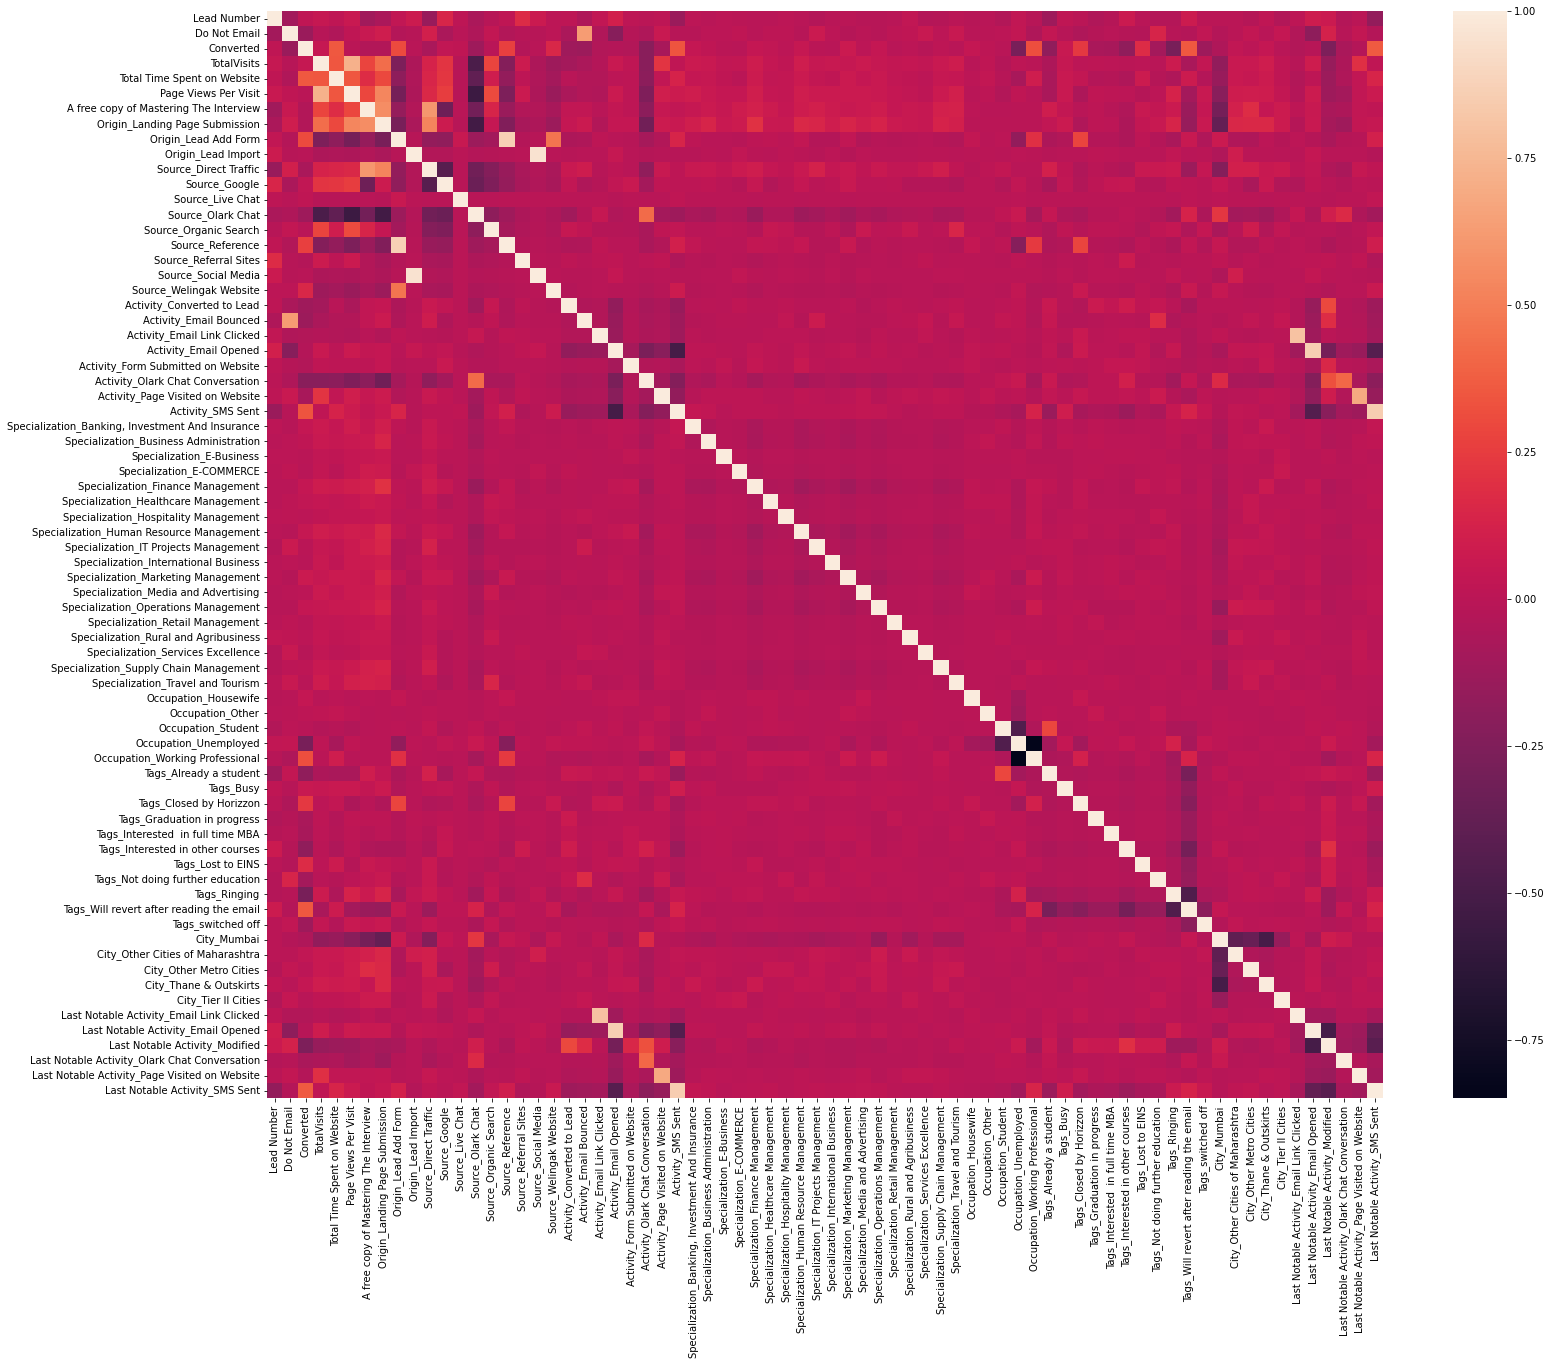

In [95]:
# Let's see the correlation matrix 
plt.figure(figsize = (25,20))        # Size of the figure
sns.heatmap(lead_df.corr())
plt.show()